# Survival analysis with GNN and Cox Model
In this notebook, we implement the whole pipeline to make survival analysis with Cox Model and GNN.

## Pipeline description
0. Reading dataset, drop censored patients, and label patients.
1. Build the graph to connect samples
2. Train the GNN for binary survival classification (event / no event) to learn the patients embeddings
3. Extract learnt patients embeddings
4. Train the Cox Model with new patients embeddings to predict survival metrics.

In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchtuples as tt
from torch.nn import Linear
from models.BuildGraph import BuildGraph
from models.GCNClassifier import GCNClassifier
from manage.GCNTrainTestManager import GCNTrainTestManager
from pycox.models import CoxPH
from torch_geometric.utils import from_networkx

## 0. Reading dataset and drop censored patients
We use the dataset from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163. We drop the non naive patients.

In [286]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,Overall survival (days),Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,391,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,544,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,408,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,11,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,385,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,401,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,96,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,441,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,158,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


### Delete censored patients
In statistics, some patients can have non faithful metrics, because of leaving the study for example. In our context, we want to drop patients which have not experienced an event (status = 0) and where the time of event is less than a given time t (which represents the time when we look at). Indeed, it might represent a precocious leaving of the patient ; what happened between the time of leaving and the time t when we look at ?

In [287]:
def drop_censored_patients(df: pd.DataFrame, status_name: str, time_name: str, t: float)->pd.DataFrame:
    """ 
    Delete censored patients from the initial dataframe. A censored patient is a patient with status = 0 and time_event < t.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe without censored patients.
    """

    # Get index of to drop patients
    to_drop = df.index[np.where((df[status_name] == 0) & (df[time_name]<t))[0]]
    print(f"{to_drop.shape[0]} patients censored deleted")

    # Update dataframe
    df_non_censored = df.drop(to_drop,axis=0)

    return df_non_censored

In [288]:
## TTP (Time To Progression)
t_ttp = np.median(df["Time to progression (days)"].to_numpy())
df_ttp_non_censored = drop_censored_patients(df, "Progression_1", "Time to progression (days)", t_ttp)

## OS (Overall survival)
t_os = np.median(df["Overall survival (days)"].to_numpy())
df_os_non_censored = drop_censored_patients(df, "Alive_0", "Overall survival (days)", t_os)

6 patients censored deleted
1 patients censored deleted


### Label patients for future classification
Now, we want to create a label column to split event occured patients and no event occured patients : 
- status = 1 and time < t : class 1 (the event occured)
- status = 1 and time > t : class 0 (the event has not occured yet at the time when we look at. The event will occur later)
- status = 0 and time > t : class 0 (the event has not occured at the time when we look at)
- status = 0 and time < t : censored patients, we already dropped these patients.

Because we already dropped censored patients, we can see that we just have to test if time < t. If yes, we label 1, otherwise, we label 0.

In [289]:
def label_patients(df: pd.DataFrame, time_name: str, t: float)->pd.DataFrame:
    """ 
    Create new column in dataframe with event label depending on status, time and t values.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe with an extra label column.
    """
    
    # We test if time < t (1 if yes, 0 otherwise)
    df["event_occured"] = np.where(df[time_name]<t, 1, 0)
    
    return df

In [290]:
## TTP :
df_ttp_non_censored = label_patients(df_ttp_non_censored, "Time to progression (days)",t_ttp)

## OS :
df_os_non_censored = label_patients(df_os_non_censored, "Overall survival (days)",t_os)

## 1. Build the graph to connect patients
For now, we gather patients with the same tumour type, and, for each tumour type, all patients are inter-connected.

In [291]:
## TTP :
buildgraph_ttp = BuildGraph(df_ttp_non_censored)

## OS :
buildgraph_os = BuildGraph(df_os_non_censored)

### Create adjacency matrix
If 2 patients have the same tumour type, we put 1 if the corresponding case in adjacency matrix. Otherwise, we put 0.

In [292]:
## TTP :
buildgraph_ttp.compute_adjacency_matrix("Tumour type")

## OS :
buildgraph_os.compute_adjacency_matrix("Tumour type")

### Create the graph from adjacency matrix
Each node of the graph contains its features and its label. Then, with the adjacency matrix, we connect nodes. The resulting graph is under networkx format. 

In [293]:
# Name of the features for each node
features_name = ["CD8+ T cell score","Exome mut per mb"]

# Name of the label for each node
label_name = "event_occured"

## TTP :
buildgraph_ttp.create_graph(features_name, label_name)

## OS :
buildgraph_os.create_graph(features_name, label_name)

### Vizualize the graph
Let's see what our graphs look like.

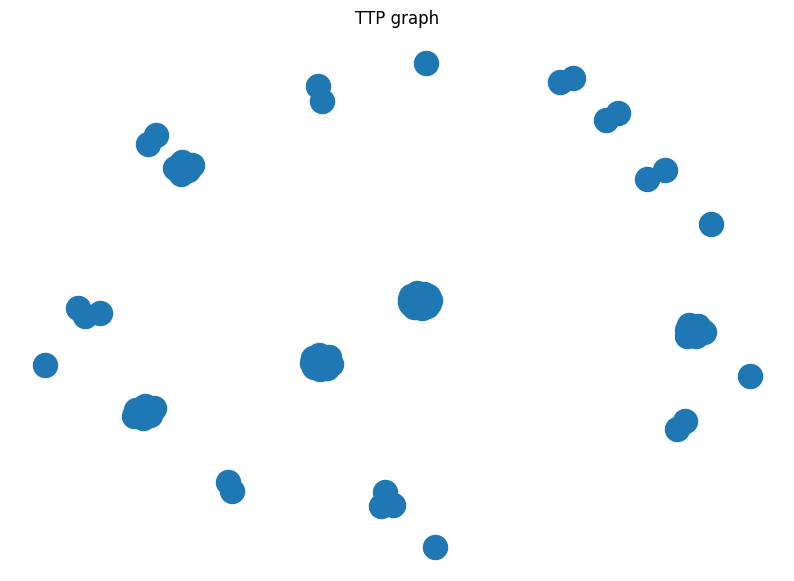

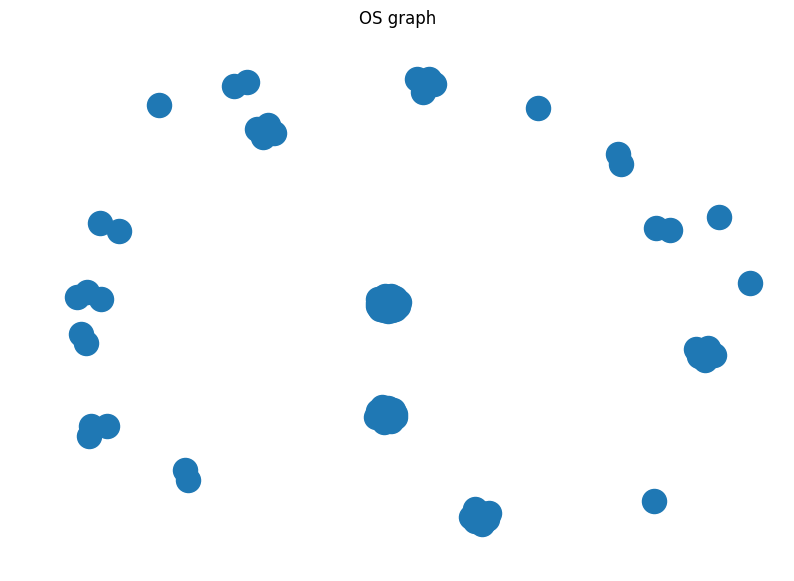

In [294]:
## TTP :
buildgraph_ttp.show_graph("TTP graph","ttp-graph.png")

## OS :
buildgraph_os.show_graph("OS graph","os-graph.png")

### Convert the graph into PyTorch Geometric format
For the following section, we need to convert the networkx graph to a PyTorch geometric one.

In [295]:
## TTP :
pyg_graph_ttp = from_networkx(buildgraph_ttp.G)

## OS :
pyg_graph_os = from_networkx(buildgraph_os.G)

## 2. Train the GNN for binary survival classification
Now, we want to learn the patients embeddings. Because a library which learns the Cox parameters and GNN parameters does not exist, we need to split the process in 2 steps : first, learn the GNN parameters for the equivalent classification problem, and then, use the learnt embeddings to make the Cox regression. Here, we are at step 1.

In [296]:
## TTP :
gcn_classifier_ttp = GCNClassifier(num_features=len(features_name))

## OS :
gcn_classifier_os = GCNClassifier(num_features=len(features_name))

### Define training loss and optimizers, and instanciate train managers
We use the Binary Cross Entropy Loss, and the Adam optimizer. 

In [297]:
# Loss :
loss_function_ttp = torch.nn.BCELoss()
loss_function_os = torch.nn.BCELoss()

# Optimizer :
optimizer_ttp = torch.optim.Adam(gcn_classifier_ttp.parameters(), lr=0.01)
optimizer_os = torch.optim.Adam(gcn_classifier_os.parameters(), lr=0.01)

In [298]:
## TTP : 
train_manager_ttp = GCNTrainTestManager(gcn_classifier_ttp, pyg_graph_ttp, loss_function_ttp, optimizer_ttp)

## OS :
train_manager_os = GCNTrainTestManager(gcn_classifier_os, pyg_graph_os, loss_function_os, optimizer_os)

### Training

In [299]:
## TTP :
train_manager_ttp.train(n_epochs=100)

Epoch 1 of 100
Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100


Epoch 91 of 100
End of training.


In [300]:
## OS :
train_manager_os.train(n_epochs=100)

Epoch 1 of 100
Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100
Epoch 91 of 100
End of training.


### Plot train loss

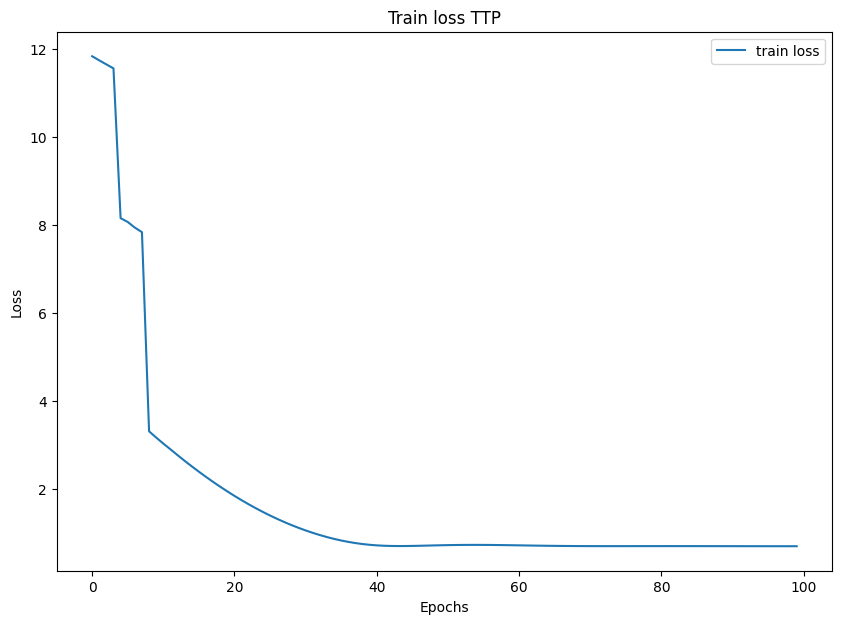

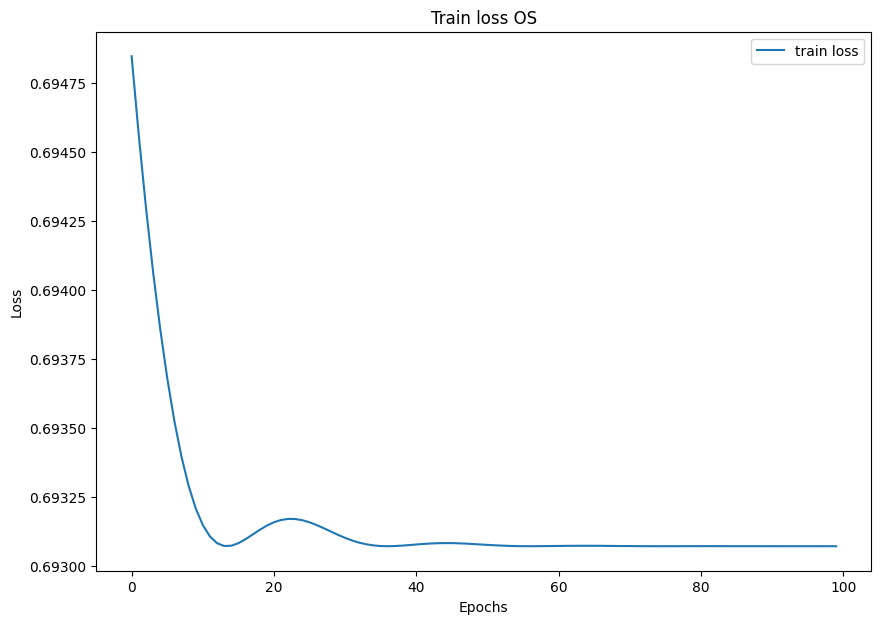

In [301]:
## TTP :
train_manager_ttp.plot_loss("Train loss TTP","train-loss-ttp.png")

## OS :
train_manager_os.plot_loss("Train loss OS","train-loss-os.png")

## 3. Extract learnt patients embeddings
With the previous section, we learnt parameters of GCN classifier. So we can extract new patients embeddings, where each patient has its features and the features of its neighbours. For that, we apply the convolutive layer in our GCN model.

In [302]:
## TTP : 
df_ttp_learnt = pd.DataFrame(gcn_classifier_ttp.forward_conv(pyg_graph_ttp.x, pyg_graph_ttp.edge_index).detach().numpy(), columns=features_name, index=df_ttp_non_censored.index)
print("Initial embeddings : ")
display(df_ttp_non_censored.loc[:,features_name])
print("New embeddings : ")
display(df_ttp_learnt)

Initial embeddings : 


,CD8+ T cell score,Exome mut per mb
0,0.351869,11.095310
1,0.071464,3.876336
2,0.040394,2.415688
4,0.009323,4.606660
6,0.351194,1.432559
...,...,...
92,0.695396,84.998501
94,0.818233,2.247151
95,0.018982,3.848247
96,0.000000,5.617878


New embeddings : 


,CD8+ T cell score,Exome mut per mb
0,7.452606,5.534058
1,1.316341,0.820711
2,1.101951,0.693374
4,7.452606,5.534058
6,7.452606,5.534057
...,...,...
92,7.452606,5.534057
94,0.972002,0.025972
95,2.969316,1.947648
96,1.540721,1.045411


In [303]:
## OS : 
df_os_learnt = pd.DataFrame(gcn_classifier_os.forward_conv(pyg_graph_os.x, pyg_graph_os.edge_index).detach().numpy(), columns=features_name, index=df_os_non_censored.index)
print("Initial embeddings : ")
display(df_os_non_censored.loc[:,features_name])
print("New embeddings : ")
display(df_os_learnt)

Initial embeddings : 


,CD8+ T cell score,Exome mut per mb
0,0.351869,11.095310
1,0.071464,3.876336
2,0.040394,2.415688
3,0.052774,6.235845
4,0.009323,4.606660
...,...,...
92,0.695396,84.998501
94,0.818233,2.247151
95,0.018982,3.848247
96,0.000000,5.617878


New embeddings : 


,CD8+ T cell score,Exome mut per mb
0,-9.528066,-8.426764
1,-2.181489,-1.960931
2,-1.909238,-1.698961
3,-20.608652,-18.111814
4,-9.528065,-8.426764
...,...,...
92,-9.528066,-8.426764
94,-3.585621,-3.397892
95,-15.737401,-13.889432
96,-2.501357,-2.211589


## 4. Train Cox Model with new embeddings
Now, we can integrate the new dataframe into a Cox Model. We will use the PyCox library. In PyCox, we define first the network for the regression (which estimates the Cox Model function). Next, we add over the survival analysis model to estimate the survival metrics.

### Preprocessing data
We need to extract features under numpy format, and to format the labels as follow : (list_status, list_time).

In [304]:
## TTP :
X_ttp = df_ttp_learnt.to_numpy()
get_target_ttp = lambda df: (df['Progression_1'].values, df['Time to progression (days)'].values)
y_ttp = get_target_ttp(df_ttp_non_censored)

## OS :
X_os = df_os_learnt.to_numpy()
get_target_os = lambda df: (df['Alive_0'].values, df['Overall survival (days)'].values)
y_os = get_target_os(df_os_non_censored)

### Implement Regression network
Because we have few data, we define a neural network with only 1 layer (no hidden layer).

In [305]:
class netCoxModel(torch.nn.Module):
    """ 
    Cox regression network. 1 fully connected layer here.
    """
    def __init__(self, in_features: int)->None:

        super().__init__()
        
        # Regression layer
        self.regression = Linear(in_features=in_features, out_features=1) 

    def forward(self, x):
        return self.regression(x)

In [306]:
## TTP :
net_ttp = netCoxModel(in_features=len(features_name))

## OS :
net_os = netCoxModel(in_features=len(features_name))

### Implement CoxPH model over the regression network
In our context, the model we use is the Cox Proportional Hazard Model, implemented in the CoxPH model in PyCox. We use the Adam optimizer for the gradient descent.

In [307]:
## TTP :
cox_model_ttp = CoxPH(net=net_ttp, optimizer=torch.optim.Adam(net_ttp.parameters(),lr=0.01))

## OS :
cox_model_os = CoxPH(net=net_os, optimizer=torch.optim.Adam(net_os.parameters(),lr=0.01))

### Train the CoxPH model and plot train loss

In [308]:
## TTP
history_train_ttp = cox_model_ttp.fit(X_ttp, y_ttp, epochs=100, verbose=True)

0:	[0s / 0s],		train_loss: 4.2673
1:	[0s / 0s],		train_loss: 4.6006
2:	[0s / 0s],		train_loss: 4.0994
3:	[0s / 0s],		train_loss: 3.9677
4:	[0s / 0s],		train_loss: 4.0272
5:	[0s / 0s],		train_loss: 3.9237
6:	[0s / 0s],		train_loss: 4.0026
7:	[0s / 0s],		train_loss: 3.6761
8:	[0s / 0s],		train_loss: 3.6300
9:	[0s / 0s],		train_loss: 3.6757
10:	[0s / 0s],		train_loss: 3.6315
11:	[0s / 0s],		train_loss: 3.5559
12:	[0s / 0s],		train_loss: 3.7550
13:	[0s / 0s],		train_loss: 3.5966
14:	[0s / 0s],		train_loss: 3.5603
15:	[0s / 0s],		train_loss: 3.5183
16:	[0s / 0s],		train_loss: 3.6284
17:	[0s / 0s],		train_loss: 3.6758
18:	[0s / 0s],		train_loss: 3.7350
19:	[0s / 0s],		train_loss: 3.6320
20:	[0s / 0s],		train_loss: 3.6042
21:	[0s / 0s],		train_loss: 3.6366
22:	[0s / 0s],		train_loss: 3.6556
23:	[0s / 0s],		train_loss: 3.7109
24:	[0s / 0s],		train_loss: 3.6839
25:	[0s / 0s],		train_loss: 3.6557
26:	[0s / 0s],		train_loss: 3.7386
27:	[0s / 0s],		train_loss: 3.7173
28:	[0s / 0s],		train_loss: 3.

59:	[0s / 0s],		train_loss: 3.4683
60:	[0s / 0s],		train_loss: 3.5537
61:	[0s / 0s],		train_loss: 3.6686
62:	[0s / 0s],		train_loss: 3.7307
63:	[0s / 0s],		train_loss: 3.6116
64:	[0s / 0s],		train_loss: 3.5419
65:	[0s / 0s],		train_loss: 3.4529
66:	[0s / 0s],		train_loss: 3.6140
67:	[0s / 0s],		train_loss: 3.5391
68:	[0s / 0s],		train_loss: 3.6514
69:	[0s / 0s],		train_loss: 3.6957
70:	[0s / 0s],		train_loss: 3.7321
71:	[0s / 0s],		train_loss: 3.6330
72:	[0s / 0s],		train_loss: 3.6693
73:	[0s / 0s],		train_loss: 3.6316
74:	[0s / 0s],		train_loss: 3.5803
75:	[0s / 0s],		train_loss: 3.6694
76:	[0s / 0s],		train_loss: 3.5982
77:	[0s / 0s],		train_loss: 3.4916
78:	[0s / 0s],		train_loss: 3.5482
79:	[0s / 0s],		train_loss: 3.6714
80:	[0s / 0s],		train_loss: 3.7054
81:	[0s / 0s],		train_loss: 3.5742
82:	[0s / 0s],		train_loss: 3.5928
83:	[0s / 0s],		train_loss: 3.5632
84:	[0s / 0s],		train_loss: 3.6715
85:	[0s / 0s],		train_loss: 3.5411
86:	[0s / 0s],		train_loss: 3.6788
87:	[0s / 0s],		trai

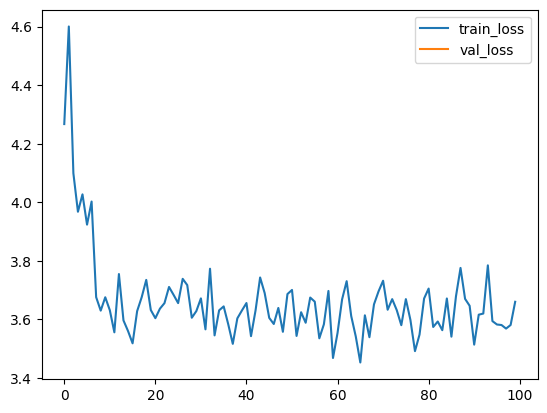

In [309]:
_ = history_train_ttp.plot()

In [310]:
## OS
history_train_os = cox_model_os.fit(X_os, y_os, epochs=100, verbose=True)

0:	[0s / 0s],		train_loss: 19.3706
1:	[0s / 0s],		train_loss: 13.5195
2:	[0s / 0s],		train_loss: 17.8237
3:	[0s / 0s],		train_loss: 17.8014
4:	[0s / 0s],		train_loss: 17.3637
5:	[0s / 0s],		train_loss: 16.9477
6:	[0s / 0s],		train_loss: 15.4737
7:	[0s / 0s],		train_loss: 12.7041
8:	[0s / 0s],		train_loss: 9.2944
9:	[0s / 0s],		train_loss: 14.1634
10:	[0s / 0s],		train_loss: 11.5895
11:	[0s / 0s],		train_loss: 12.7275
12:	[0s / 0s],		train_loss: 10.0255
13:	[0s / 0s],		train_loss: 9.5628
14:	[0s / 0s],		train_loss: 8.7124
15:	[0s / 0s],		train_loss: 10.6728
16:	[0s / 0s],		train_loss: 8.2334
17:	[0s / 0s],		train_loss: 11.4313
18:	[0s / 0s],		train_loss: 10.6541
19:	[0s / 0s],		train_loss: 9.0357
20:	[0s / 0s],		train_loss: 10.3651
21:	[0s / 0s],		train_loss: 6.3450
22:	[0s / 0s],		train_loss: 7.8614
23:	[0s / 0s],		train_loss: 5.9698
24:	[0s / 0s],		train_loss: 5.6026
25:	[0s / 0s],		train_loss: 7.0408
26:	[0s / 0s],		train_loss: 5.4971
27:	[0s / 0s],		train_loss: 6.3079
28:	[0s / 0s],

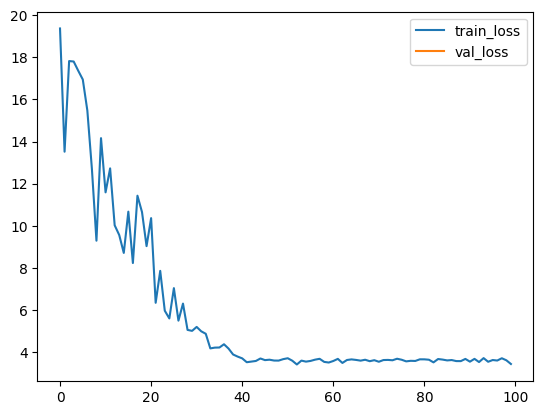

In [311]:
_ = history_train_os.plot()